In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

import glob
import os
import boto3
from sqlalchemy import create_engine, MetaData, Table, select, and_, func
from sqlalchemy.orm import sessionmaker, relationship, join
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import Table, Column, Integer, ForeignKey
from sqlalchemy.orm import relationship
from aquabyte.optics import convert_to_world_point, depth_from_disp, pixel2world, euclidean_distance
from aquabyte.data_access_utils import DataAccessUtils

import pickle
from PIL import Image, ImageDraw

pd.set_option('max_columns', 500)
pd.set_option('max_colwidth', 50)

<h1> Establish connection to database and perform query for base dataset </h1>

In [5]:
# AWS credentials
aws_credentials = json.load(open(os.environ["AWS_CREDENTIALS"]))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
                         aws_secret_access_key=aws_credentials["aws_secret_access_key"],
                         region_name="eu-west-1")


# prod SQL credentaials
sql_credentials = json.load(open(os.environ["PROD_SQL_CREDENTIALS"]))

sql_query = '''
select * from keypoint_annotations
where captured_at >= '2019-05-15'
and site_id = 23
and pen_id = 4;
'''

original_df = extract_from_database(sql_query, sql_credentials)
original_df = original_df.loc[:, ~original_df.columns.duplicated()]
        

NameError: name 'extract_from_database' is not defined

<h1> Iterate over query results and generate 3D coordinates + biomass estimates for each stereo fish detection </h1>

In [3]:
def coord2biomass_linear(world_keypoints, model):
    """from coordinates to biomass"""

    mean = model['mean']
    std= model['std']
    PCA_components = model['PCA_components']
    reg_coef = model['reg_coef']
    reg_intercept = model['reg_intercept']
    body_parts = model['body_parts']

    # calculate pairwise distances for production coord
    # based on the exact ordering reflected in the body_parts
    # variable above

    pairwise_distances = []
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            dist = euclidean_distance(world_keypoints[body_parts[i]], world_keypoints[body_parts[j]])
            pairwise_distances.append(dist)
    
    interaction_values = []
    for i in range(len(pairwise_distances)):
        for j in range(i, len(pairwise_distances)):
            dist1 = pairwise_distances[i]
            dist2 = pairwise_distances[j]
            interaction_values.append(dist1 * dist2)

    X = np.array(pairwise_distances + interaction_values)

    X_normalized = (X - model['mean']) / model['std']
    X_transformed = np.dot(X_normalized, model['PCA_components'].T)
    prediction = np.dot(X_transformed, reg_coef) + reg_intercept
    return prediction


def coord2biomass_blender(world_keypoints, blender):
    """from coordinates to biomass"""

    reverse_mapping = blender["reverse_mapping"]
    distances = np.array(blender["distances"])
    volumes = blender["volume"]
    regression_coeff = blender["coeff"]

    # calculate pairwise distances for production coord
    # the reverse mapping insure that we listing the kp
    # in the same order
    measurements = []
    number_of_parts = len(world_keypoints)
    for k in range(number_of_parts):
        v = world_keypoints[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = world_keypoints[reverse_mapping[str(k0)]]
            dist = euclidean_distance(v, v0)*1000 # mm to m
            measurements.append(dist)
    measurements = np.array(measurements)

    # absolute diff
    diff = np.nanmean(np.abs(distances - measurements), axis=1)
    closest = np.argmin(diff)
    prediction = volumes[closest]

    # here is some machine learning
    prediction = prediction*regression_coeff[0] + regression_coeff[1]
    return prediction



In [ ]:
def generate_rotation_matrix(u_base, v):
    u = v / np.linalg.norm(v)
    n = np.cross(u_base, u)
    n = n / np.linalg.norm(n)
    theta = -np.arccos(np.dot(u, u_base))

    R = np.array([[
        np.cos(theta) + n[0]**2*(1-np.cos(theta)), 
        n[0]*n[1]*(1-np.cos(theta)) - n[2]*np.sin(theta),
        n[0]*n[2]*(1-np.cos(theta)) + n[1]*np.sin(theta)
    ], [
        n[1]*n[0]*(1-np.cos(theta)) + n[2]*np.sin(theta),
        np.cos(theta) + n[1]**2*(1-np.cos(theta)),
        n[1]*n[2]*(1-np.cos(theta)) - n[0]*np.sin(theta),
    ], [
        n[2]*n[0]*(1-np.cos(theta)) - n[1]*np.sin(theta),
        n[2]*n[1]*(1-np.cos(theta)) + n[0]*np.sin(theta),
        np.cos(theta) + n[2]**2*(1-np.cos(theta))
    ]])
    
    return R

def normalize_world_keypoints(world_keypoint_coordinates):
    body_parts = sorted(world_keypoint_coordinates.keys())
    wkps = {bp: np.array(world_keypoint_coordinates[bp]) for bp in body_parts}
    
    # translate keypoints such that tail notch is at origin
    translated_wkps = {bp: wkps[bp] - wkps['TAIL_NOTCH'] for bp in body_parts}
    
    # perform first rotation
    u_base=np.array([1, 0, 0])
    v = translated_wkps['UPPER_LIP']
    R = generate_rotation_matrix(u_base, v)
    norm_wkps_intermediate = {bp: np.dot(R, translated_wkps[bp]) for bp in body_parts}
    
    # perform second rotation
    u_base = np.array([0, 0, 1])
    v = norm_wkps_intermediate['DORSAL_FIN'] - np.array([norm_wkps_intermediate['DORSAL_FIN'][0], 0, 0])
    R = generate_rotation_matrix(u_base, v)
    norm_wkps = {bp: np.dot(R, norm_wkps_intermediate[bp]) for bp in body_parts}
    
    return norm_wkps
    


In [7]:
# load model parameters for Blender and linear models
model = pickle.load(open('/root/data/alok/biomass_estimation/models/model.pkl', 'rb'))
blender = json.load(open('/root/data/alok/biomass_estimation/models/volumes.json'))


# establish new columns
mask = (original_df.is_skipped == False) & (~original_df.keypoints.isnull())
for col in ['left_keypoints', 'right_keypoints', 'world_keypoint_coordinates']:
    original_df[col] = np.nan
    original_df[col] = original_df[col].astype(object)
for col in ['predicted_biomass_linear', 'predicted_biomass_blender', 
            'max_y_coordinate_deviation', 'max_y_world_coordinate_deviation']:
    original_df[col] = np.nan


# modify the dataframe row-by-row
for idx, row in original_df[mask].iterrows():
    keypoints = row.keypoints
    left_keypoints = keypoints['leftCrop']
    right_keypoints = keypoints['rightCrop']
            
    # compute world coordinates
    camera_metadata = row.camera_metadata
    camera_metadata['pixelCountHeight'] = 3000
    camera_metadata['pixelCountWidth'] = 4096
    world_keypoint_coordinates = pixel2world(left_keypoints, right_keypoints, camera_metadata)
    
    # update dataframe with world keypoint coordinates
    original_df.at[idx, 'left_keypoints'] = left_keypoints
    original_df.at[idx, 'right_keypoints'] = right_keypoints
    original_df.at[idx, 'world_keypoint_coordinates'] = world_keypoint_coordinates
    
    body_parts = sorted(list(world_keypoint_coordinates.keys()))
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            bp1, bp2 = body_parts[i], body_parts[j]
            col = '{}<->{}'.format(body_parts[i], body_parts[j])
            if not col in original_df.columns:
                original_df[col] = np.nan
            original_df.at[idx, col] = \
                euclidean_distance(world_keypoint_coordinates[bp1], world_keypoint_coordinates[bp2])
    
    # update dataframe with biomass predictions from both models
    predicted_biomass_linear = coord2biomass_linear(world_keypoint_coordinates, model)
    predicted_biomass_blender = coord2biomass_blender(world_keypoint_coordinates, blender)
    original_df.at[idx, 'predicted_biomass_linear'] = predicted_biomass_linear
    original_df.at[idx, 'predicted_biomass_blender'] = predicted_biomass_blender
    
    # update dataframe with keypoint deviation
    threshold = 10
    left_keypoint_y_coords = {bp['keypointType']: bp['yFrame'] for bp in left_keypoints}
    right_keypoint_y_coords = {bp['keypointType']: bp['yFrame'] for bp in right_keypoints}
    max_y_coordinate_deviation = \
        max([abs(left_keypoint_y_coords[bp] - right_keypoint_y_coords[bp]) for bp in body_parts])
    
    original_df.at[idx, 'max_y_coordinate_deviation'] = max_y_coordinate_deviation
    
    # add 3D range for world coordinate y-values
    
    
    norm_wkps = normalize_world_keypoints(world_keypoint_coordinates)
    norm_wkp_y_values = [norm_wkps[bp][1] for bp in norm_wkps.keys()]
    max_y_world_coordinate_deviation = max(norm_wkp_y_values) - min(norm_wkp_y_values)
    original_df.at[idx, 'max_y_world_coordinate_deviation'] = max_y_world_coordinate_deviation



<h1> Apply filters </h1>

In [8]:
invalid_fish_detection_ids = json.load(open('/root/data/alok/biomass_estimation/invalid_fish_detection_ids.json'))
df = original_df.copy(deep=True)

# define filters
valid_linear_prediction_mask = ~df.predicted_biomass_linear.isnull()
rectification_valid_mask = (~df.fish_detection_id.isin(invalid_fish_detection_ids))
keypoints_valid_mask = (df.max_y_coordinate_deviation < 15)
qa_mask = df.is_qa = True
mask = valid_linear_prediction_mask & rectification_valid_mask & keypoints_valid_mask & qa_mask

df = df[mask].copy(deep=True)
df.index = pd.to_datetime(df.captured_at)



<h1> Pairwise Distance Distributions </h1>

Here, we plot the distributions of the pairwise distance features. This will allow us to visibly spot and potentially diagnose bad biomass estimates, and give more insights as to why the linear PCA model may be failing.

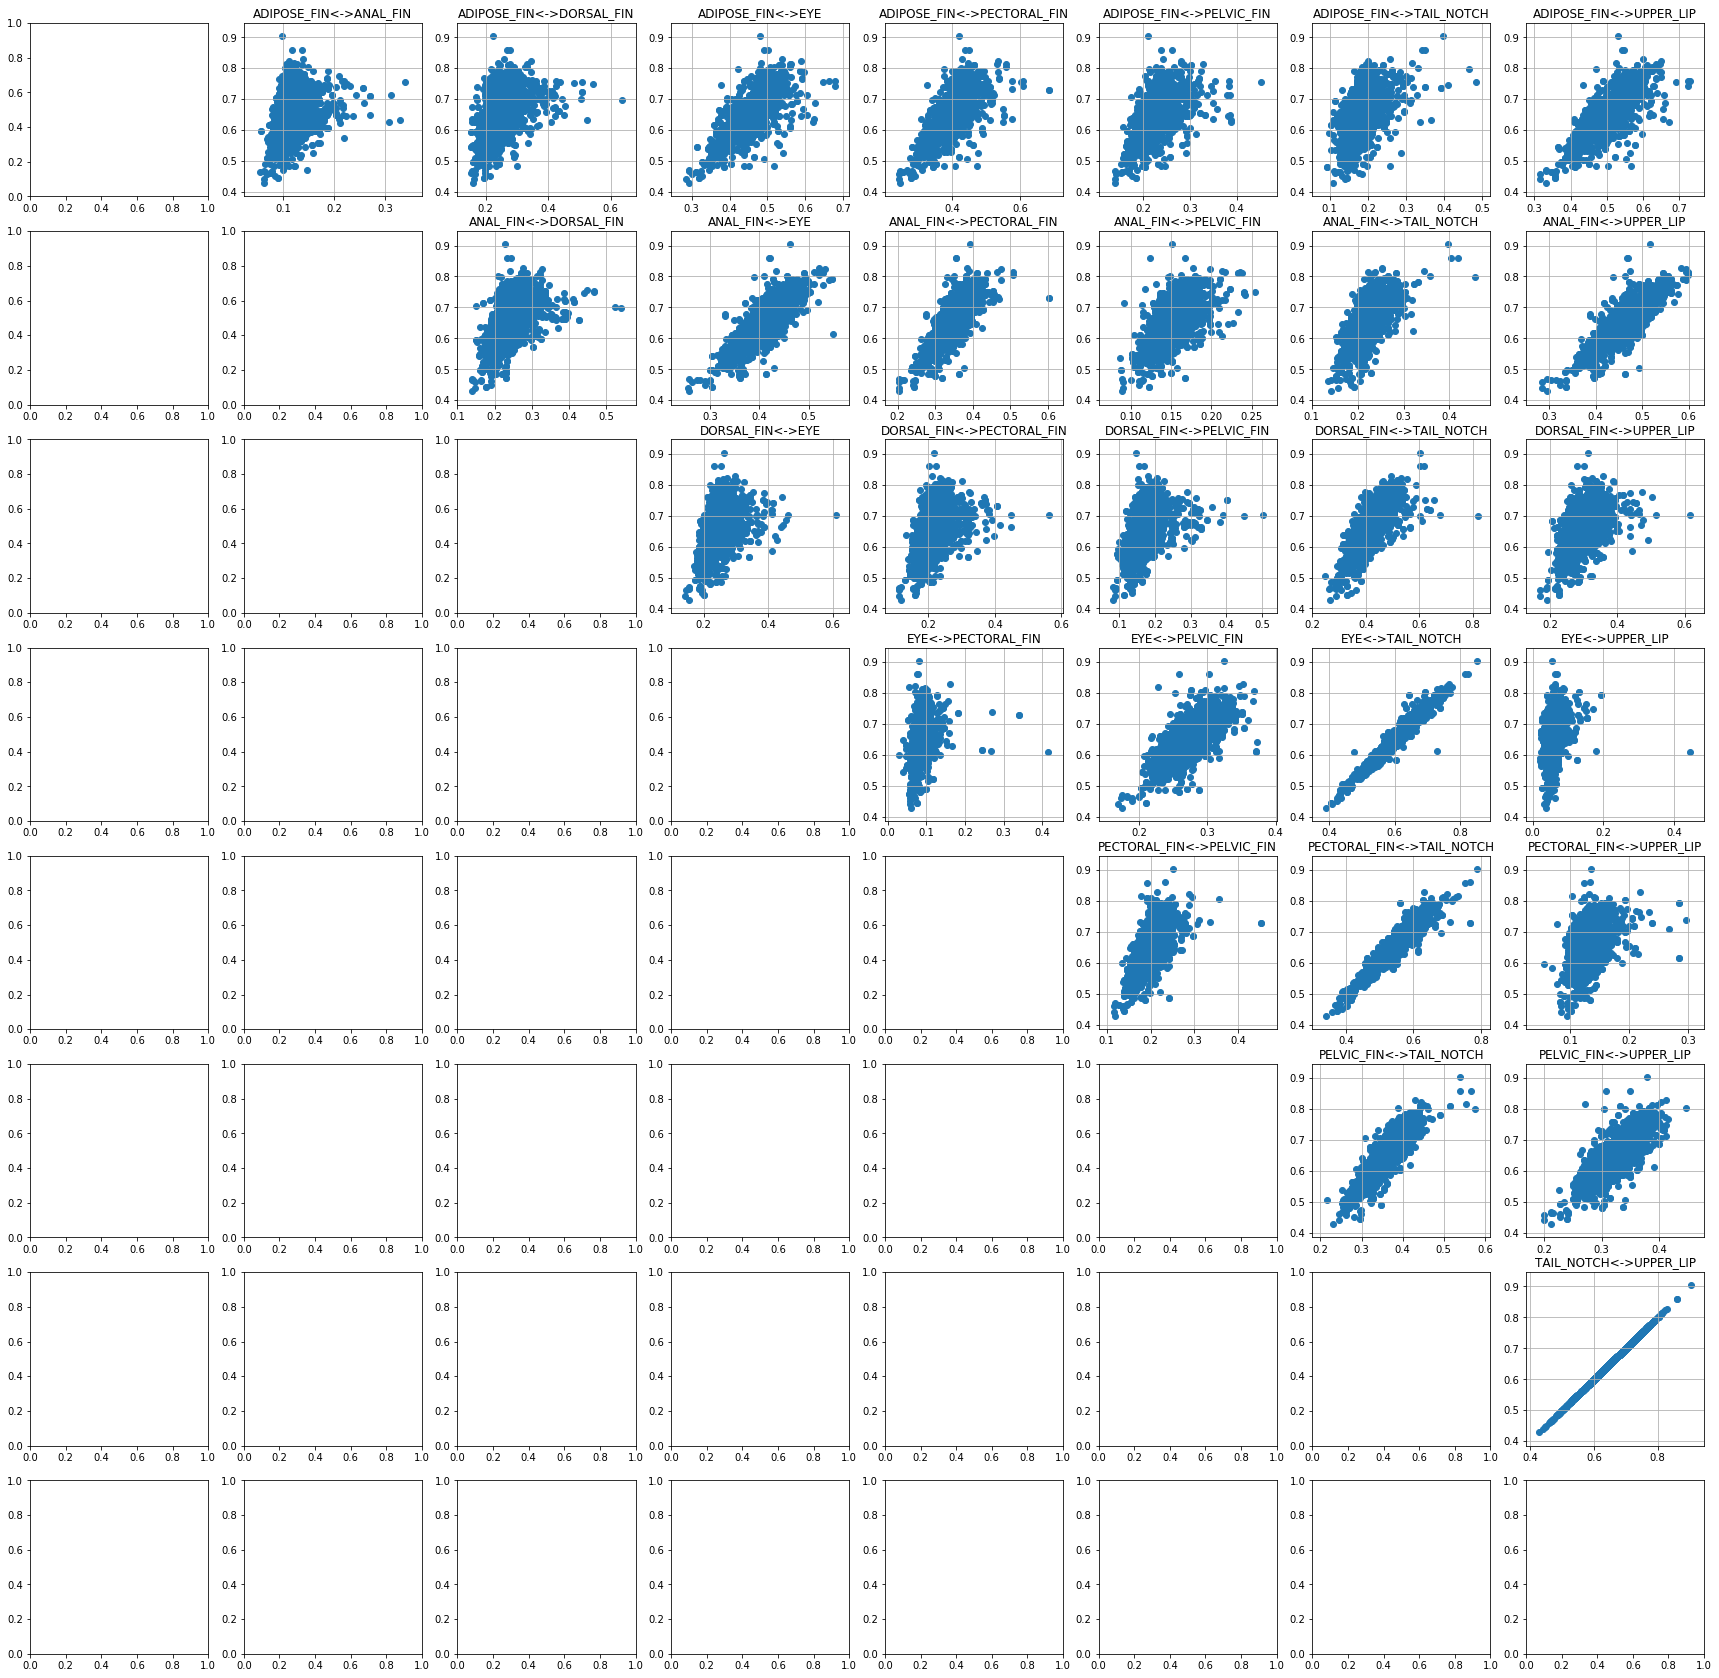

In [9]:
body_parts = sorted([item['keypointType'] for item in df.left_keypoints.iloc[0]])
N = len(body_parts)
fig, axes = plt.subplots(N, N, figsize=(30, 30))
i = 1
for i, bp1 in enumerate(body_parts):
    for j, bp2 in enumerate(body_parts):
        if bp1 >= bp2:
            continue
        axes[i, j].scatter(df['{}<->{}'.format(bp1, bp2)], df['TAIL_NOTCH<->UPPER_LIP'])
        axes[i, j].grid()
        axes[i, j].set_title('{}<->{}'.format(bp1, bp2))
        
        

<h1> Create filter / annotation score based on 3D coordinates </h1>

In [10]:
df.sort_values('max_y_world_coordinate_deviation', ascending=False)

id  fish_detection_id  \
captured_at                                                   
2019-05-17 09:27:34.265000+00:00  109804                NaN   
2019-05-18 09:23:04.180000+00:00  115037                NaN   
2019-05-15 11:14:00.785000+00:00   97854                NaN   
2019-05-15 11:14:00.785000+00:00   97971                NaN   
2019-05-15 06:55:34.230000+00:00   95894                NaN   
2019-05-15 06:29:27.148000+00:00   95631                NaN   
2019-05-19 06:13:35.423000+00:00  117541                NaN   
2019-05-15 11:06:27.112000+00:00   97704                NaN   
2019-05-19 07:53:09.935000+00:00  118402                NaN   
2019-05-19 06:49:42.963000+00:00  117862                NaN   
2019-05-16 11:18:43.119000+00:00  105973                NaN   
2019-05-16 11:18:43.119000+00:00  105885                NaN   
2019-05-19 07:58:15.928000+00:00  118497                NaN   
2019-05-17 09:24:58.899000+00:00  110060                NaN   
2019-05-16 11:14:31.430000+00:00  105837                NaN   
2019-05-16 12:52:56.203000+00:00  106871                NaN   
2019-05-16 12:52:56.203000+00:00  106939                NaN   
2019-05-18 07:41:44.545000+00:00  113888                NaN   
2019-05-18 07:41:44.545000+00:00  113625                NaN   
2019-05-18 08:40:51.741000+00:00  114389                NaN   
2019-05-15 12:40:19.271000+00:00   99884                NaN   
2019-05-15 12:40:19.271000+00:00   99482                NaN   
2019-05-16 06:49:09.213000+00:00  102636                NaN   
2019-05-16 06:49:09.213000+00:00  101987                NaN   
2019-05-16 11:12:11.478000+00:00  105810                NaN   
2019-05-16 12:08:45.112000+00:00  106601                NaN   
2019-05-16 12:08:45.112000+00:00  107102                NaN   
2019-05-19 06:08:17.533000+00:00  117930                NaN   
2019-05-16 07:21:44.772000+00:00  102400                NaN   
2019-05-16 08:20:41.859000+00:00  103433                NaN   
...                                  ...                ...   
2019-05-18 07:49:52.093000+00:00  113768                NaN   
2019-05-18 07:49:52.093000+00:00  113794                NaN   
2019-05-19 10:20:46.037000+00:00  119095                NaN   
2019-05-19 06:33:45.404000+00:00  117816                NaN   
2019-05-18 09:21:18.268000+00:00  114827                NaN   
2019-05-18 09:21:18.268000+00:00  115026                NaN   
2019-05-18 06:39:36.621000+00:00  113561                NaN   
2019-05-18 06:39:36.621000+00:00  112982                NaN   
2019-05-20 06:15:56.624000+00:00  120033                NaN   
2019-05-16 10:55:56.255000+00:00  105540                NaN   
2019-05-16 10:55:56.255000+00:00  105603                NaN   
2019-05-19 10:49:52.806000+00:00  119604                NaN   
2019-05-17 06:08:43.724000+00:00  108117                NaN   
2019-05-15 13:32:40.188000+00:00  100258                NaN   
2019-05-16 12:18:02.304000+00:00  106664                NaN   
2019-05-15 13:55:54.236000+00:00  100718                NaN   
2019-05-16 06:12:14.642000+00:00  101474                NaN   
2019-05-16 12:32:59.606000+00:00  106713                NaN   
2019-05-16 12:32:59.606000+00:00  107039                NaN   
2019-05-17 12:17:51.533000+00:00  111485                NaN   
2019-05-15 10:42:11.967000+00:00   96978                NaN   
2019-05-17 12:17:51.533000+00:00  111407                NaN   
2019-05-15 12:07:20.163000+00:00   98795                NaN   
2019-05-20 06:15:56.624000+00:00  120146                NaN   
2019-05-15 11:32:52.558000+00:00   98364                NaN   
2019-05-15 11:32:52.558000+00:00   98311                NaN   
2019-05-20 06:33:34.267000+00:00  120140                NaN   
2019-05-16 10:18:07.949000+00:00  104761                NaN   
2019-05-17 12:17:02.482000+00:00  111383                NaN   
2019-05-19 07:59:15.239000+00:00  118507                NaN   

                                     annotated_by_email  is_qa is_sk

In [11]:
plt.hist(df.predicted_biomass_linear, bins=100)

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.,   0.,   3.,   2.,   0.,   4.,   6.,   5.,   7.,  26.,  35.,
         53.,  80., 129., 154., 217., 272., 294., 293., 292., 236., 182.,
        153., 146.,  95.,  61.,  42.,  39.,  24.,  23.,  13.,  19.,   8.,
          9.,   6.,   7.,   7.,   1.,   4.,   4.,   4.,   4.,   6.,   2.,
          1.,   0.,   1.,   0.,   2.,   3.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3913.80972536, -3667.01261863, -3420.2155119 , -3173.41840517,
        -2926.62129844, -2679.82419171, -2433.02708498, -2186.22997825,
        -1939.43287152, -1692.6357648 , -1445.83865807, -1199.04155134,
         -952.24444461,  -705.44733788,  -458.65023115,  -211.85312442,
           34.94398231,   281.

(array([  1.,   8.,   2.,   5.,  10.,  32.,  26.,  36.,  69., 100., 121.,
        152., 181., 243., 232., 244., 237., 191., 170., 143., 110., 107.,
         85.,  43.,  45.,  32.,  26.,  19.,  15.,  15.,   9.,  12.,   5.,
          9.,   5.,   3.,   6.,   2.,   1.,   3.,   3.,   2.,   3.,   3.,
          5.,   2.,   1.,   0.,   0.,   0.,   1.,   1.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  159.76139416,   365.82278969,   571.88418523,   777.94558076,
          984.0069763 ,  1190.06837183,  1396.12976736,  1602.1911629 ,
         1808.25255843,  2014.31395397,  2220.3753495 ,  2426.43674504,
         2632.49814057,  2838.55953611,  3044.62093164,  3250.68232717,
         3456.74372271,  3662.

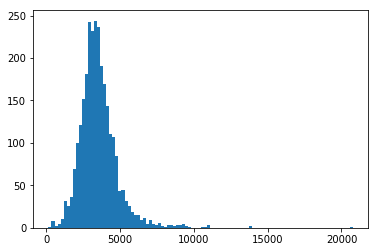

In [12]:
mask = df.max_y_world_coordinate_deviation < 0.15
plt.hist(df[mask].predicted_biomass_linear, bins=100)

In [13]:
plt.hist(df.max_y_world_coordinate_deviation, bins=100)

(array([  1.,   1.,   2.,  11.,  29.,  26.,  37.,  46.,  66.,  75.,  86.,
        110., 107.,  99., 136., 141., 150., 185., 179., 164., 164., 137.,
        117., 141., 124., 123.,  85.,  63.,  77.,  54.,  38.,  42.,  31.,
         16.,  22.,  17.,  15.,   6.,  12.,   5.,   3.,   4.,   4.,   3.,
          3.,   9.,   2.,   0.,   4.,   1.,   0.,   4.,   0.,   2.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00845574, 0.0130108 , 0.01756587, 0.02212094, 0.026676  ,
        0.03123107, 0.03578614, 0.0403412 , 0.04489627, 0.04945134,
        0.05400641, 0.05856147, 0.06311654, 0.06767161, 0.07222667,
        0.07678174, 0.08133681, 0.08589187, 0.09044694, 0.09500201,
        0.09955708, 0.10411214, 0.10866721, 0.

In [14]:
df[mask].sort_values('predicted_biomass_linear', ascending=False)

id  fish_detection_id  \
captured_at                                                   
2019-05-20 07:06:07.360000+00:00  120395                NaN   
2019-05-18 09:23:37.390000+00:00  114899                NaN   
2019-05-16 10:42:17.577000+00:00  105389                NaN   
2019-05-16 07:09:31.995000+00:00  102382                NaN   
2019-05-15 11:00:44.395000+00:00   97240                NaN   
2019-05-18 09:32:37.981000+00:00  114963                NaN   
2019-05-15 11:05:26.056000+00:00   97294                NaN   
2019-05-15 10:41:05.419000+00:00   96980                NaN   
2019-05-15 11:11:50.841000+00:00   97518                NaN   
2019-05-17 09:04:38.307000+00:00  109486                NaN   
2019-05-17 09:27:18.178000+00:00  109845                NaN   
2019-05-15 11:06:49.612000+00:00   97322                NaN   
2019-05-15 11:06:49.612000+00:00   97495                NaN   
2019-05-16 09:21:41.957000+00:00  103976                NaN   
2019-05-18 11:35:40.373000+00:00  116108                NaN   
2019-05-18 11:35:40.373000+00:00  116574                NaN   
2019-05-15 06:40:17.820000+00:00   96419                NaN   
2019-05-16 11:10:49.425000+00:00  105846                NaN   
2019-05-16 11:10:49.425000+00:00  105691                NaN   
2019-05-18 11:32:06.420000+00:00  116019                NaN   
2019-05-18 14:24:05.757000+00:00  117241                NaN   
2019-05-18 07:11:10.683000+00:00  113299                NaN   
2019-05-20 06:16:15.967000+00:00  121252                NaN   
2019-05-20 06:16:15.967000+00:00  120013                NaN   
2019-05-17 08:24:38.701000+00:00  108709                NaN   
2019-05-16 11:46:51.685000+00:00  106175                NaN   
2019-05-20 07:03:49.565000+00:00  120388                NaN   
2019-05-15 13:18:57.921000+00:00  100624                NaN   
2019-05-16 12:38:07.831000+00:00  106835                NaN   
2019-05-15 10:41:05.419000+00:00   97025                NaN   
...                                  ...                ...   
2019-05-15 10:07:05.555000+00:00   96756                NaN   
2019-05-15 11:13:15.459000+00:00   97781                NaN   
2019-05-20 06:49:12.355000+00:00  120260                NaN   
2019-05-18 14:00:49.914000+00:00  117195                NaN   
2019-05-18 08:09:59.792000+00:00  114062                NaN   
2019-05-15 06:28:24.551000+00:00   96644                NaN   
2019-05-15 06:28:24.551000+00:00   95793                NaN   
2019-05-15 07:01:52.870000+00:00   96053                NaN   
2019-05-16 09:45:48.858000+00:00  105405                NaN   
2019-05-16 09:45:48.858000+00:00  104336                NaN   
2019-05-15 12:27:12.633000+00:00   99238                NaN   
2019-05-17 10:50:55.123000+00:00  110545                NaN   
2019-05-18 06:21:55.332000+00:00  112793                NaN   
2019-05-18 06:21:55.332000+00:00  114128                NaN   
2019-05-18 11:33:19.659000+00:00  116308                NaN   
2019-05-20 06:33:34.267000+00:00  121111                NaN   
2019-05-20 06:33:34.267000+00:00  120140                NaN   
2019-05-18 13:41:25.846000+00:00  117131                NaN   
2019-05-16 13:19:56.566000+00:00  107103                NaN   
2019-05-16 11:31:59.462000+00:00  105978                NaN   
2019-05-18 12:42:17.121000+00:00  116614                NaN   
2019-05-18 08:23:54.407000+00:00  114204                NaN   
2019-05-19 11:41:44.314000+00:00  119431                NaN   
2019-05-19 11:41:44.314000+00:00  119611                NaN   
2019-05-20 06:42:08.741000+00:00  120955                NaN   
2019-05-16 06:20:56.940000+00:00  101681                NaN   
2019-05-16 09:59:28.177000+00:00  104690                NaN   
2019-05-16 09:59:28.177000+00:00  104837                NaN   
2019-05-18 08:23:54.407000+00:00  114226                NaN   
2019-05-20 06:42:08.741000+00:00  120198                NaN   

                                     annotated_by_email  is_qa is_sk

In [15]:
depths = []
lengths = []
thetas = []
curvature_thetas = []
for wkp in df['world_keypoint_coordinates'].tolist():
    y_values = [x[1] for x in wkp.values()]
    mean_depth = np.array(y_values).mean()
    depths.append(mean_depth)
    length = euclidean_distance(wkp['UPPER_LIP'], wkp['TAIL_NOTCH'])
    lengths.append(length)
    direction_vector = np.array(wkp['UPPER_LIP']) - np.array(wkp['TAIL_NOTCH'])
    direction_vector[0] = 0
    base_vector = np.array([0, 0, 1]) if wkp['UPPER_LIP'][2] > wkp['TAIL_NOTCH'][2] else np.array([0, 0, -1])
    theta = (180 / np.pi) * np.arccos(np.dot(direction_vector, base_vector) / np.linalg.norm(direction_vector))
    thetas.append(theta)
    
    # calculate curvature
    wkp = {bp: [wkp[bp][2], wkp[bp][1], wkp[bp][0]] for bp in body_parts}
    fv1 = np.array(wkp['UPPER_LIP']) - np.array(wkp['DORSAL_FIN'])
    fv2 = np.array(wkp['UPPER_LIP']) - np.array(wkp['PELVIC_FIN'])
    n1 = np.cross(fv1, fv2)
    
    bv1 = np.array(wkp['PELVIC_FIN']) -  np.array(wkp['TAIL_NOTCH'])
    bv2 = np.array(wkp['DORSAL_FIN']) -  np.array(wkp['TAIL_NOTCH'])
    n2 = np.cross(bv1, bv2)
    curvature_theta = (180 / np.pi) * np.arccos(np.dot(n1, n2) / (np.linalg.norm(n1) * np.linalg.norm(n2)))
    curvature_thetas.append(curvature_theta)
    
    
    



In [16]:
tdf = pd.DataFrame({'depth': depths, 'length': lengths, 'weight': df.predicted_biomass_blender.values})
df['theta'] = thetas
df['curvature'] = curvature_thetas

In [17]:
depth_values = np.arange(0.8, 2.0, 0.1)
x_ticks = []
conditional_lengths = []
conditional_weights = []
for i in range(len(depth_values) - 1):
    depth_range_mask = (tdf.depth > depth_values[i]) & (tdf.depth < depth_values[i+1])
    conditional_length = tdf[depth_range_mask].length.mean()
    conditional_lengths.append(conditional_length)
    conditional_weight = tdf[depth_range_mask].weight.mean()
    conditional_weights.append(conditional_weight)
    x_tick = (depth_values[i] + depth_values[i+1]) / 2.0
    x_ticks.append(x_tick)
    

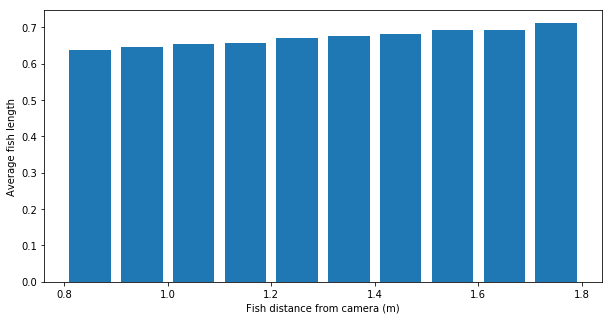

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(x_ticks, conditional_lengths, width=0.08)
plt.xlabel('Fish distance from camera (m)')
plt.ylabel('Average fish length')
plt.show()

In [19]:
plt.figure(figsize=(10, 5))
plt.bar(x_ticks, conditional_weights, width=0.08)
plt.xlabel('Fish distance from camera (m)')
plt.ylabel('Average fish weight')
plt.show()

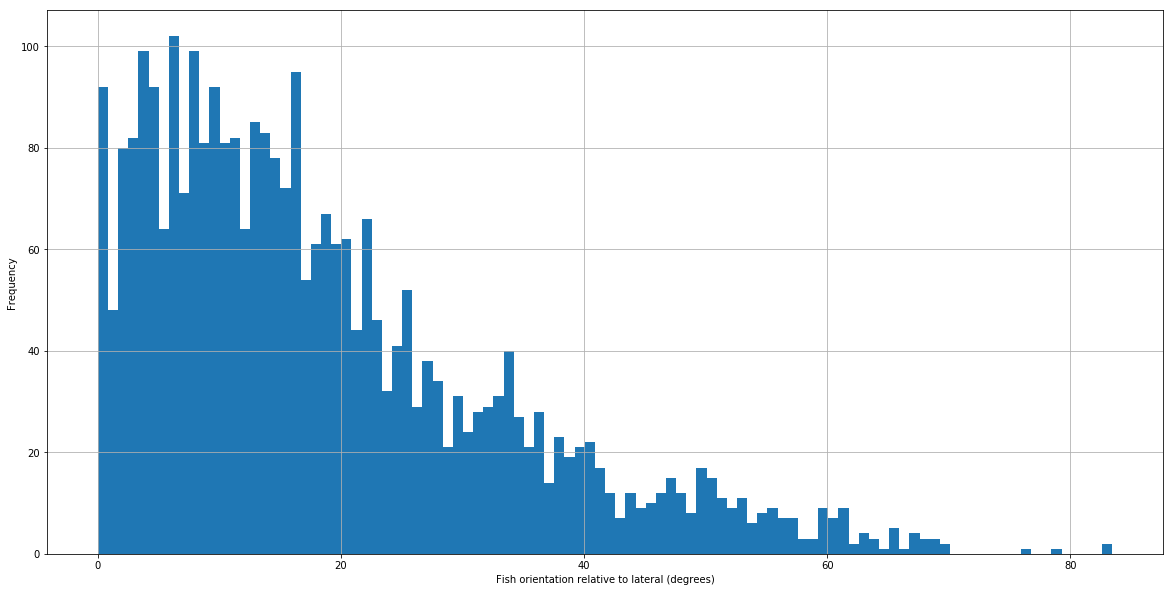

In [20]:
plt.figure(figsize=(20, 10))
plt.hist(thetas, bins=100)
plt.xlabel('Fish orientation relative to lateral (degrees)')
plt.ylabel('Frequency')
plt.grid()

In [21]:
plt.figure(figsize=(20, 10))
plt.hist(depths, bins=100)
plt.xlabel('Fish depth (meters)')
plt.ylabel('Frequency')
plt.grid()

<h1> Curvature </h1>

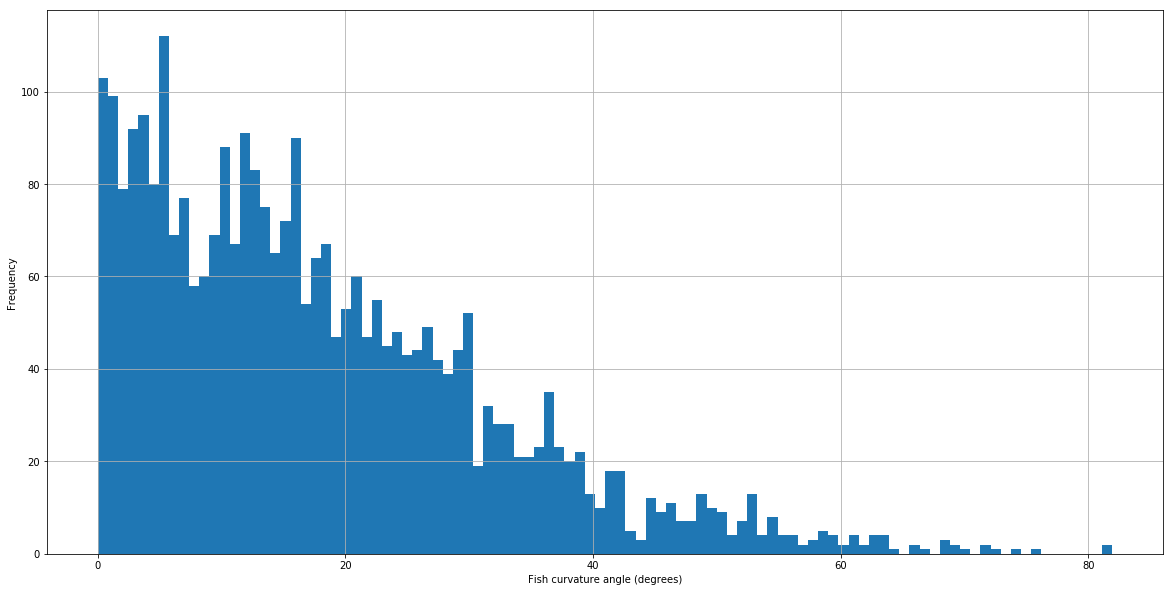

In [23]:
plt.figure(figsize=(20, 10))
plt.hist(curvature_thetas, bins=100)
plt.xlabel('Fish curvature angle (degrees)')
plt.ylabel('Frequency')
plt.grid()

<h1> Examine the worst cases </h1>

In [260]:
df.sort_values('curvature', ascending=True)

id  fish_detection_id  \
captured_at                                                   
2019-05-16 10:31:25.649000+00:00  105116                NaN   
2019-05-16 11:44:28.657000+00:00  106130                NaN   
2019-05-16 06:51:07.110000+00:00  102169                NaN   
2019-05-16 10:07:35.673000+00:00  104743                NaN   
2019-05-16 08:49:26.070000+00:00  103696                NaN   
2019-05-15 06:19:54.075000+00:00   95511                NaN   
2019-05-15 11:14:27.648000+00:00   97885                NaN   
2019-05-15 11:12:06.923000+00:00   97766                NaN   
2019-05-15 11:12:06.923000+00:00   97665                NaN   
2019-05-16 05:57:48.378000+00:00  101323                NaN   
2019-05-16 05:57:48.378000+00:00  101339                NaN   
2019-05-15 11:07:25.104000+00:00   97398                NaN   
2019-05-15 11:07:25.104000+00:00   98868                NaN   
2019-05-16 07:41:36.772000+00:00  104495                NaN   
2019-05-15 06:31:39.556000+00:00   95975                NaN   
2019-05-16 09:29:33.057000+00:00  104206                NaN   
2019-05-16 06:06:53.466000+00:00  101437                NaN   
2019-05-16 07:03:31.700000+00:00  102192                NaN   
2019-05-16 07:03:31.700000+00:00  102386                NaN   
2019-05-16 13:17:10.668000+00:00  107368                NaN   
2019-05-16 10:18:28.176000+00:00  105128                NaN   
2019-05-16 10:18:28.176000+00:00  104921                NaN   
2019-05-16 09:21:58.054000+00:00  103974                NaN   
2019-05-15 10:52:32.531000+00:00   97064                NaN   
2019-05-15 07:22:46.620000+00:00   96137                NaN   
2019-05-16 11:10:49.425000+00:00  105691                NaN   
2019-05-16 11:10:49.425000+00:00  105846                NaN   
2019-05-15 11:04:57.697000+00:00   97341                NaN   
2019-05-15 11:19:59.431000+00:00   98112                NaN   
2019-05-15 11:19:59.431000+00:00   97983                NaN   
...                                  ...                ...   
2019-05-16 06:26:44.487000+00:00  101692                NaN   
2019-05-16 12:01:00.461000+00:00  106402                NaN   
2019-05-16 13:23:25.645000+00:00  107159                NaN   
2019-05-16 12:06:17.428000+00:00  106415                NaN   
2019-05-15 12:27:53.531000+00:00   99279                NaN   
2019-05-15 12:27:53.531000+00:00   99231                NaN   
2019-05-15 07:24:30.150000+00:00   96527                NaN   
2019-05-16 10:14:45.568000+00:00  104947                NaN   
2019-05-15 12:33:10.840000+00:00   99367                NaN   
2019-05-16 08:41:59.777000+00:00  103425                NaN   
2019-05-16 11:28:45.355000+00:00  105946                NaN   
2019-05-15 06:33:48.198000+00:00   95722                NaN   
2019-05-15 11:23:24.206000+00:00   98232                NaN   
2019-05-15 11:23:24.206000+00:00   98626                NaN   
2019-05-16 06:29:01.250000+00:00  101719                NaN   
2019-05-15 08:21:20.494000+00:00   96659                NaN   
2019-05-15 08:21:20.494000+00:00   96660                NaN   
2019-05-15 11:03:23.209000+00:00   97274                NaN   
2019-05-16 06:16:37.396000+00:00  101643                NaN   
2019-05-16 07:02:40.079000+00:00  102234                NaN   
2019-05-16 07:02:40.079000+00:00  102318                NaN   
2019-05-16 06:32:51.281000+00:00  101840                NaN   
2019-05-16 10:37:20.109000+00:00  105144                NaN   
2019-05-16 10:37:20.109000+00:00  106327                NaN   
2019-05-16 06:39:30.217000+00:00  102040                NaN   
2019-05-16 06:39:30.217000+00:00  101847                NaN   
2019-05-15 06:15:17.176000+00:00   95595                NaN   
2019-05-15 11:21:49.749000+00:00   97852                NaN   
2019-05-16 06:18:58.066000+00:00  101476                NaN   
2019-05-16 06:18:58.066000+00:00  101522                NaN   

                                     annotated_by_email  is_qa is_sk

In [25]:
def plot_coordinates(image_url, side, keypoints):
    image_f = './image.jpg'
#     bucket = 'aquabyte-frames-resized-inbound'
    bucket = 'aquabyte-crops'
    key = image_url[image_url.index('aquabyte-crops') + len('aquabyte-crops') + 1:]
    s3_client.download_file(bucket, key, image_f)
    plt.figure(figsize=(30, 10))
    im = plt.imread(image_f)
    
    for keypoint in keypoints:
        keypoint_type = keypoint['keypointType']
        x, y = keypoint['xCrop'], keypoint['yCrop']
#         plt.scatter([x], [y])
#         plt.annotate(keypoint_type, (x, y), color='red')
        
    plt.imshow(im)        
    

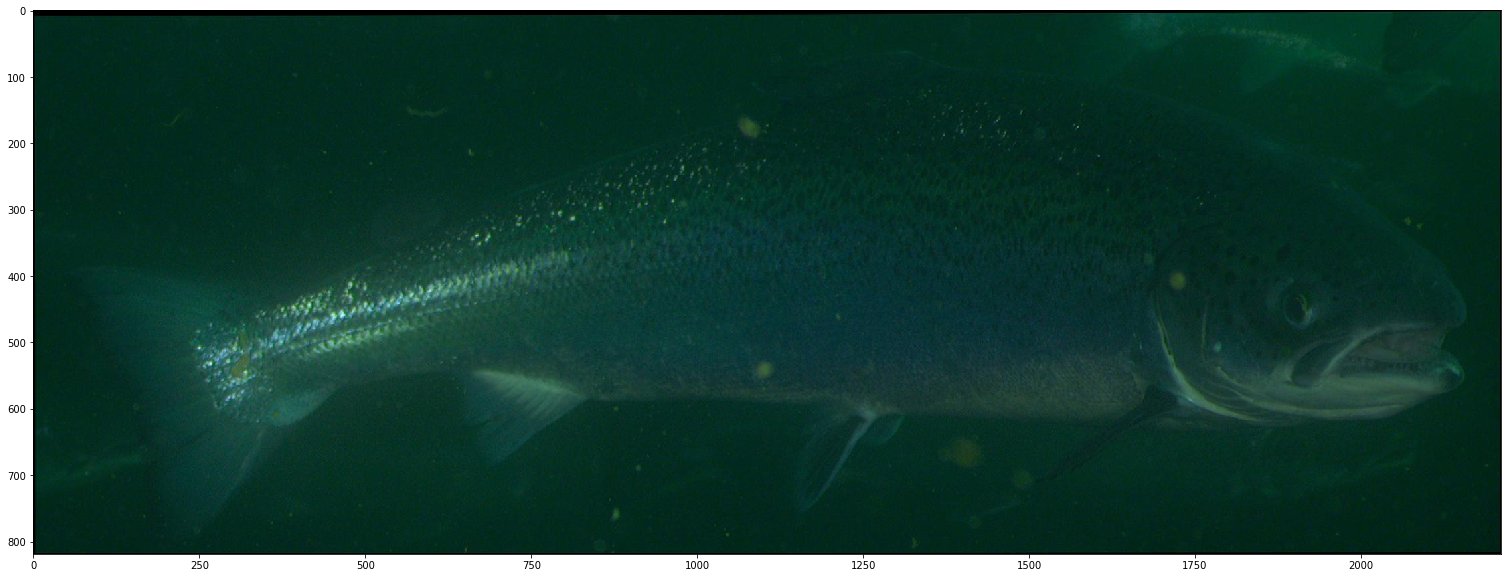

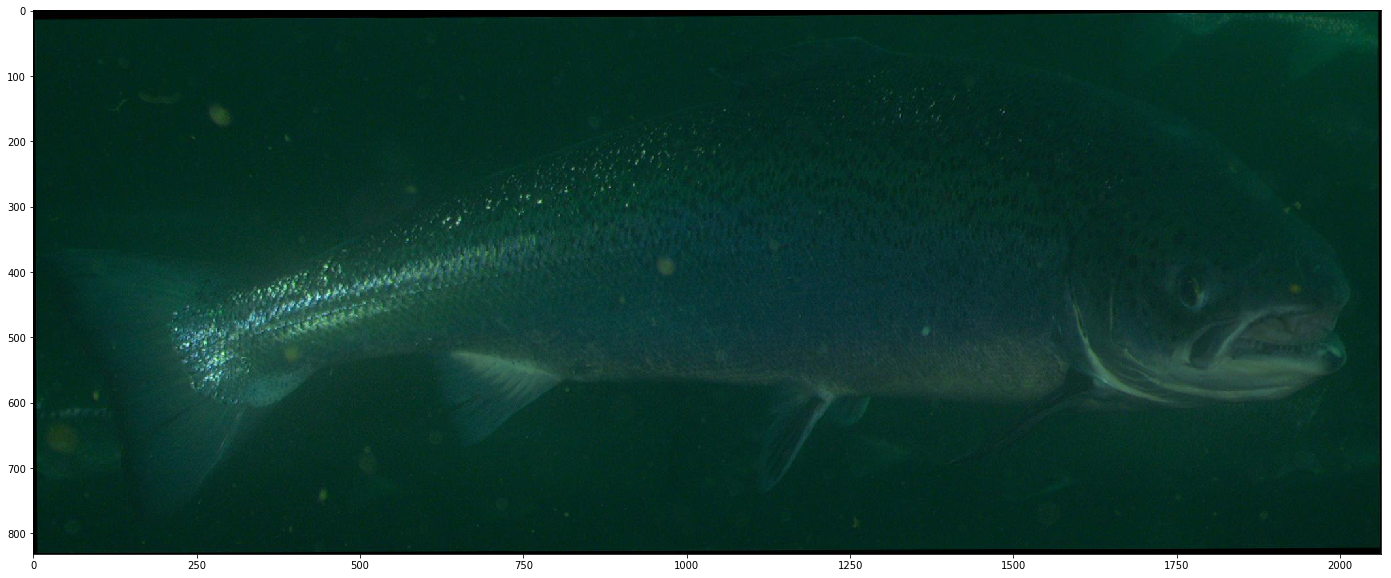

In [27]:
keypoint_annotation_id = 101847
keypoint_annotation_mask = (df.id == keypoint_annotation_id)
left_image_url = df[keypoint_annotation_mask].left_image_url.iloc[0]
left_keypoints = df[keypoint_annotation_mask].left_keypoints.iloc[0]
right_image_url = df[keypoint_annotation_mask].right_image_url.iloc[0]
right_keypoints = df[keypoint_annotation_mask].right_keypoints.iloc[0]

world_keypoint_coordinates = df[keypoint_annotation_mask].world_keypoint_coordinates.iloc[0]
im_left = plot_coordinates(left_image_url, 'left', left_keypoints)
im_right = plot_coordinates(right_image_url, 'right', right_keypoints)

In [119]:
right_image_url

'https://s3-eu-west-1.amazonaws.com/aquabyte-crops/environment=production/site-id=23/pen-id=4/date=2019-05-16/hour=07/at=2019-05-16T07:09:31.995525000Z/right_frame_crop_166_342_2442_1139.jpg'

In [117]:
norm_wkps = normalize_world_keypoints(world_keypoint_coordinates)
[(bp, norm_wkps[bp][1]) for bp in norm_wkps.keys()]

[('TAIL_NOTCH', 0.0),
 ('DORSAL_FIN', -9.107298248878237e-18),
 ('ANAL_FIN', 0.03100175536321385),
 ('ADIPOSE_FIN', -0.014111849795069506),
 ('PELVIC_FIN', 0.0718921959589633),
 ('PECTORAL_FIN', 0.05540161334358816),
 ('UPPER_LIP', 5.551522916199874e-17),
 ('EYE', 0.018994151837423753)]

In [98]:
bp = 'TAIL_NOTCH'
disp = [i['xFrame'] for i in left_keypoints if i['keypointType'] == bp][0] - [i['xFrame'] for i in right_keypoints if i['keypointType'] == bp][0]



In [99]:
(camera_metadata['focalLengthPixel'] * camera_metadata['baseline'])/disp

1.7398086365266852

In [100]:
print(disp)

228


In [120]:
imleft_keypoints

NameError: name 'imleft_keypoints' is not defined

In [241]:
bgr = cv2.imread('./image.jpg')
lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)
gridsize = 16
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
lab_planes[0] = clahe.apply(lab_planes[0])
lab = cv2.merge(lab_planes)
bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

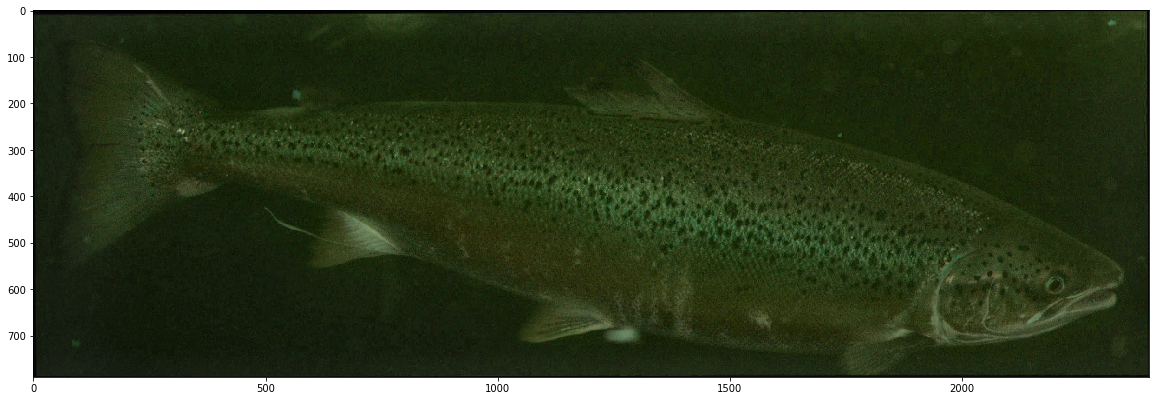

In [242]:
plt.figure(figsize=(20, 10))
plt.imshow(bgr)

In [155]:
left_image_url

'https://s3-eu-west-1.amazonaws.com/aquabyte-crops/environment=production/site-id=23/pen-id=4/date=2019-05-16/hour=10/at=2019-05-16T10:42:17.577842000Z/left_frame_crop_726_1631_3010_2270.jpg'

In [123]:
def load_params(params_file):
    params = json.load(open(params_file))
    cameraMatrix1 = np.array(params['CameraParameters1']['IntrinsicMatrix']).transpose()
    cameraMatrix2 = np.array(params['CameraParameters2']['IntrinsicMatrix']).transpose()

    distCoeffs1 = params['CameraParameters1']['RadialDistortion'][0:2] + \
                   params['CameraParameters1']['TangentialDistortion'] + \
                   [params['CameraParameters1']['RadialDistortion'][2]]
    distCoeffs1 = np.array(distCoeffs1)

    distCoeffs2 = params['CameraParameters2']['RadialDistortion'][0:2] + \
                   params['CameraParameters2']['TangentialDistortion'] + \
                   [params['CameraParameters2']['RadialDistortion'][2]]
    distCoeffs2 = np.array(distCoeffs2)

    R = np.array(params['RotationOfCamera2']).transpose()
    T = np.array(params['TranslationOfCamera2']).transpose()

    imageSize = (4096, 3000)
    
    # perform rectification
    (R1, R2, P1, P2, Q, leftROI, rightROI) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imageSize, R, T, None, None, None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)

    left_maps = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imageSize, cv2.CV_16SC2)
    right_maps = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imageSize, cv2.CV_16SC2)
    
    return left_maps, right_maps

def get_remap(crop, side, crop_metadata, stereo_params_f):
    left_maps, right_maps = load_params(stereo_params_f)
    maps = left_maps if side == 'left' else right_maps
    new_image = np.zeros([3000, 4096, 3]).astype('uint8')
    lower_left = (crop_metadata['y_coord'] + crop_metadata['height'], crop_metadata['x_coord'])
    upper_right = (crop_metadata['y_coord'], crop_metadata['x_coord'] + crop_metadata['width'])
    new_image[upper_right[0]:lower_left[0], lower_left[1]:upper_right[1], :] = np.array(crop)
    remap = cv2.remap(new_image, maps[0], maps[1], cv2.INTER_LANCZOS4)
    nonzero_indices = np.where(remap > 0)
    y_min, y_max = nonzero_indices[0].min(), nonzero_indices[0].max() 
    x_min, x_max = nonzero_indices[1].min(), nonzero_indices[1].max()
    lower_left = (y_max, x_min)
    upper_right = (y_min, x_max)
    rectified_crop = remap[upper_right[0]:lower_left[0], lower_left[1]:upper_right[1], :].copy()
    print(crop_metadata)
    rectified_crop_metadata = crop_metadata.copy()
    rectified_crop_metadata['x_coord'] = x_min
    rectified_crop_metadata['y_coord'] = y_min
    rectified_crop_metadata['width'] = x_max - x_min
    rectified_crop_metadata['height'] = y_max - y_min
    
    return remap, rectified_crop_metadata



In [124]:
stereo_params_f = './2019-04-26_blom_kjeppevikholmen_pen_1.json'
left_crop_metadata = df[fish_id_mask].left_crop_metadata.iloc[0]
left_new_image = np.zeros([3000, 4096, 3]).astype('uint8')
left_remap, rectified_left_crop_metadata = get_remap(im_left, 'left', left_crop_metadata, stereo_params_f)

right_crop_metadata = df[fish_id_mask].right_crop_metadata.iloc[0]
right_new_image = np.zeros([3000, 4096, 3]).astype('uint8')
right_remap, rectified_right_crop_metadata = get_remap(im_right, 'right', right_crop_metadata, stereo_params_f)

{'mean_luminance': 13.366224467675114, 'height': 856, 'y_coord': 2100, 'width': 1940, 'x_coord': 2078, 'qualityScore': {'darkness': 0.9819762706756592, 'quality': 0.003385568503290415, 'modelInfo': {'probability': {'is_blurry': 1, 'is_good': 0, 'is_dark': 2}, 'output_size': [3], 'model': 'Mobilenet', 'description': 'binary classification good / bad for filtering', 'input_size': [224, 224, 3]}, 'blurriness': 0.015430997125804424}, 'crop_area': 1660640}
{'mean_luminance': 15.04318362952355, 'height': 879, 'y_coord': 2047, 'width': 2164, 'x_coord': 1702, 'qualityScore': {'darkness': 0.9819762706756592, 'quality': 0.003385568503290415, 'modelInfo': {'probability': {'is_blurry': 1, 'is_good': 0, 'is_dark': 2}, 'output_size': [3], 'model': 'Mobilenet', 'description': 'binary classification good / bad for filtering', 'input_size': [224, 224, 3]}, 'blurriness': 0.015430997125804424}, 'crop_area': 1902156}


In [129]:
[(kp['keypointType'], kp['yCrop'] + rectified_left_crop_metadata['y_coord']) for kp in left_keypoints]

[('UPPER_LIP', 2232),
 ('EYE', 2292),
 ('DORSAL_FIN', 2141),
 ('ADIPOSE_FIN', 2532),
 ('TAIL_NOTCH', 2797),
 ('ANAL_FIN', 2663),
 ('PELVIC_FIN', 2590),
 ('PECTORAL_FIN', 2440)]

In [130]:
[(kp['keypointType'], kp['yCrop'] + rectified_right_crop_metadata['y_coord']) for kp in right_keypoints]

[('UPPER_LIP', 2222),
 ('EYE', 2296),
 ('DORSAL_FIN', 2145),
 ('ADIPOSE_FIN', 2463),
 ('TAIL_NOTCH', 2778),
 ('ANAL_FIN', 2663),
 ('PELVIC_FIN', 2586),
 ('PECTORAL_FIN', 2425)]

In [114]:
Image.fromarray(right_remap).save('./right_remap.jpg')
Image.fromarray(left_remap).save('./left_remap.jpg')

In [76]:
left_keypoints

[{'keypointType': 'UPPER_LIP',
  'xCrop': 1977,
  'xFrame': 4055,
  'yCrop': 133,
  'yFrame': 2233},
 {'keypointType': 'EYE',
  'xCrop': 1901,
  'xFrame': 3979,
  'yCrop': 193,
  'yFrame': 2293},
 {'keypointType': 'DORSAL_FIN',
  'xCrop': 1279,
  'xFrame': 3357,
  'yCrop': 42,
  'yFrame': 2142},
 {'keypointType': 'ADIPOSE_FIN',
  'xCrop': 477,
  'xFrame': 2555,
  'yCrop': 433,
  'yFrame': 2533},
 {'keypointType': 'TAIL_NOTCH',
  'xCrop': 103,
  'xFrame': 2181,
  'yCrop': 698,
  'yFrame': 2798},
 {'keypointType': 'ANAL_FIN',
  'xCrop': 657,
  'xFrame': 2735,
  'yCrop': 564,
  'yFrame': 2664},
 {'keypointType': 'PELVIC_FIN',
  'xCrop': 1076,
  'xFrame': 3154,
  'yCrop': 491,
  'yFrame': 2591},
 {'keypointType': 'PECTORAL_FIN',
  'xCrop': 1687,
  'xFrame': 3765,
  'yCrop': 341,
  'yFrame': 2441}]

In [77]:
right_keypoints

[{'keypointType': 'UPPER_LIP',
  'xCrop': 2080,
  'xFrame': 3782,
  'yCrop': 164,
  'yFrame': 2211},
 {'keypointType': 'EYE',
  'xCrop': 1994,
  'xFrame': 3696,
  'yCrop': 238,
  'yFrame': 2285},
 {'keypointType': 'DORSAL_FIN',
  'xCrop': 1347,
  'xFrame': 3049,
  'yCrop': 87,
  'yFrame': 2134},
 {'keypointType': 'ADIPOSE_FIN',
  'xCrop': 658,
  'xFrame': 2360,
  'yCrop': 405,
  'yFrame': 2452},
 {'keypointType': 'TAIL_NOTCH',
  'xCrop': 172,
  'xFrame': 1874,
  'yCrop': 720,
  'yFrame': 2767},
 {'keypointType': 'ANAL_FIN',
  'xCrop': 736,
  'xFrame': 2438,
  'yCrop': 605,
  'yFrame': 2652},
 {'keypointType': 'PELVIC_FIN',
  'xCrop': 1170,
  'xFrame': 2872,
  'yCrop': 528,
  'yFrame': 2575},
 {'keypointType': 'PECTORAL_FIN',
  'xCrop': 1785,
  'xFrame': 3487,
  'yCrop': 367,
  'yFrame': 2414}]

In [80]:
x

{'crop_area': 4531976,
 'height': 1348,
 'mean_luminance': 51.980444071195436,
 'qualityScore': {'blurriness': 0.016313577070832253,
  'darkness': 0.980517566204071,
  'modelInfo': {'description': 'binary classification good / bad for filtering',
   'input_size': [224, 224, 3],
   'model': 'Mobilenet',
   'output_size': [3],
   'probability': {'is_blurry': 1, 'is_dark': 2, 'is_good': 0}},
  'quality': 0.003544951556250453},
 'width': 3362,
 'x_coord': 734,
 'y_coord': 1362}

In [151]:
df['2019-05-02']['predicted_biomass_blender'].mean()

3695.6892990752403

In [284]:
mask = (df.site_id == 23) & (df.pen_id == 4) & (df.index >= '2019-04-27')
df[mask].predicted_biomass_blender.resample('D', how=lambda x: x.mean())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


captured_at
2019-04-27 00:00:00+00:00    3364.401708
2019-04-28 00:00:00+00:00    3444.337160
2019-04-29 00:00:00+00:00    3476.644612
2019-04-30 00:00:00+00:00    3441.859915
2019-05-01 00:00:00+00:00    3424.173085
2019-05-02 00:00:00+00:00    3614.478289
Freq: D, Name: predicted_biomass_blender, dtype: float64

(array([  3.,  22.,  71., 242., 298., 367., 206.,  77.,  32.,  11.]),
 array([ 667.76812834, 1215.38346234, 1762.99879634, 2310.61413034,
        2858.22946434, 3405.84479834, 3953.46013234, 4501.07546634,
        5048.69080034, 5596.30613434, 6143.92146833]),
 <a list of 10 Patch objects>)

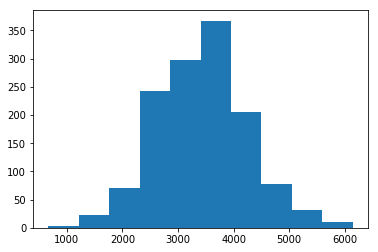

In [280]:
plt.hist(df[mask].predicted_biomass_blender)

In [232]:
df[mask].shape

(1329, 14)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


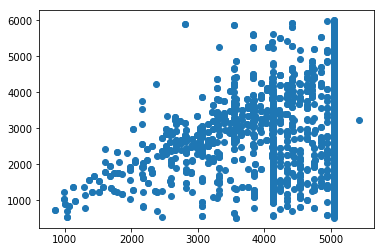

In [173]:
mask = (df.predicted_biomass_linear > 500) & (df.predicted_biomass_linear < 6000)
plt.scatter(df.ix[mask, 'predicted_biomass_blender'], df.ix[mask, 'predicted_biomass_linear'])
plt.show()

<h1> Examine rectification issue </h1>

In [117]:
df.shape

(50273, 11)

In [3]:
df = pd.read_csv('./data_dump.csv')

In [ ]:
rectified_bucket = 'aquabyte-crops'
left_image_rectified_f = './left_image_rectified.jpg'
right_image_rectified_f = './right_image_rectified.jpg'

invalid_fish_detection_ids, invalid_urls = [], []
i = 0
for idx, row in df.iterrows():
    if i % 100 == 0:
        print(i)
    i += 1
    if i < 36132:
        continue
    left_image_url = row.left_image_url
    right_image_url = row.right_image_url
    left_rectified_key = left_image_url[left_image_url.index('aquabyte-crops') + len('aquabyte-crops') + 1:]
    s3_client.download_file(rectified_bucket, left_rectified_key, left_image_rectified_f)
    right_rectified_key = right_image_url[right_image_url.index('aquabyte-crops') + len('aquabyte-crops') + 1:]
    s3_client.download_file(rectified_bucket, right_rectified_key, right_image_rectified_f)
    
    # this is dumb, can probably do this in memory
    left_rectified_image = cv2.imread(left_image_rectified_f)
    right_rectified_image = cv2.imread(right_image_rectified_f)
    
    left_crop_metadata = json.loads(row.left_crop_metadata)
    right_crop_metadata = json.loads(row.right_crop_metadata)
    left_crop_width = left_crop_metadata['width']
    left_crop_height = left_crop_metadata['height']
    right_crop_width = right_crop_metadata['width']
    right_crop_height = right_crop_metadata['height']
    
    invalid = False
    if left_rectified_image.shape[0] == left_crop_height and left_rectified_image.shape[1] == left_crop_width:
        invalid = True
        invalid_urls.append(left_image_url)
        print('left image not rectified for id {}!'.format(row.id))
    if right_rectified_image.shape[0] == right_crop_height and right_rectified_image.shape[1] == right_crop_width:
        invalid = True
        invalid_urls.append(right_image_url)
        print('right image not rectified for id {}!'.format(row.id))
    
    if invalid:
        invalid_fish_detection_ids.append(int(row.id))
    
    
    
        
    
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

left image not rectified for id 347928!
left image not rectified for id 348096!
42800
left image not rectified for id 348469!
left image not rectified for id 348658!
left image not rectified for id 348722!
left image not rectified for id 348747!
left image not rectified for id 348761!
left image not rectified for id 348783!
42900
left image not rectified for id 348883!
left image not rectified for id 348884!
left image not rectified for id 349035!
left image not rectified for id 349065!
left image not rectified for id 349178!
left image not rectified for id 349297!
43000
left image not rectified for id 349675!
left image not rectified for id 349719!
left image not rectified for id 349986!
43100
left image not rectified for id 350336!
43200
left image not rectified for id 350562!
left image not rectified for id 350808!
43300
left image not rectified for id 351129!
43400
left image not rectified for id 351427!
left image not rectified for id 351453!
left image not rectified for id 351499

In [104]:
pickle.dump(invalid_ids, open('./invalid_ids', 'wb'))

In [20]:
i

36132

In [31]:
json.dump(invalid_urls + invalid_urls_old, open('./invalid_urls.json', 'w'))

In [29]:
invalid_urls_old = json.load(open('./invalid_urls.json'))

In [30]:
invalid_fish_detection_ids_old = json.load(open('./invalid_fish_detection_ids.json'))

In [32]:
json.dump(invalid_fish_detection_ids + invalid_fish_detection_ids_old, open('./invalid_fish_detection_ids.json', 'w'))

<h1> Prod data backfill </h1>

In [144]:
sql_query = '''
select 

k.id, k.fish_detection_id, k.annotated_by_email, k.is_qa, 
k.is_skipped, k.is_blurry, k.is_dark, k.is_occluded,
k.is_bad_orientation, k.is_partial, k.direction, k.keypoints, 
k.work_duration_left_ms, k.work_duration_right_ms, f.created_at, 
f.updated_at, f.captured_at, f.site_id, f.pen_id, f.left_image_url, f.right_image_url, 
f.left_crop_metadata, f.right_crop_metadata, f.camera_metadata

from keypoint_annotations k
left join fish_detections f
on k.fish_detection_id = f.id
'''

df = extract_from_database(sql_query, sql_credentials)


In [151]:
for idx, row in df.iterrows():
    if row.keypoints:
        keypoints = row.keypoints
        left_crop_metadata = row.left_crop_metadata
        right_crop_metadata = row.right_crop_metadata
        
        for 
        
        break

{'mean_luminance': 12.556922869895347, 'height': 762, 'y_coord': 1491, 'width': 2204, 'x_coord': 654, 'qualityScore': {'darkness': 0.9823907613754272, 'quality': 0.0033735649194568396, 'modelInfo': {'probability': {'is_blurry': 1, 'is_good': 0, 'is_dark': 2}, 'output_size': [3], 'model': 'Mobilenet', 'description': 'binary classification good / bad for filtering', 'input_size': [224, 224, 3]}, 'blurriness': 0.014803665690124035}, 'crop_area': 1679448}


In [152]:
left_keypoints

[{'keypointType': 'UPPER_LIP',
  'xCrop': 2185,
  'xFrame': 2839,
  'yCrop': 623,
  'yFrame': 2114},
 {'keypointType': 'DORSAL_FIN',
  'xCrop': 1496,
  'xFrame': 2150,
  'yCrop': 282,
  'yFrame': 1773},
 {'keypointType': 'ANAL_FIN',
  'xCrop': 776,
  'xFrame': 1430,
  'yCrop': 429,
  'yFrame': 1920},
 {'keypointType': 'PECTORAL_FIN',
  'xCrop': 1835,
  'xFrame': 2489,
  'yCrop': 723,
  'yFrame': 2214},
 {'keypointType': 'PELVIC_FIN',
  'xCrop': 1208,
  'xFrame': 1862,
  'yCrop': 622,
  'yFrame': 2113},
 {'keypointType': 'EYE',
  'xCrop': 2080,
  'xFrame': 2734,
  'yCrop': 640,
  'yFrame': 2131},
 {'keypointType': 'ADIPOSE_FIN',
  'xCrop': 698,
  'xFrame': 1352,
  'yCrop': 168,
  'yFrame': 1659},
 {'keypointType': 'TAIL_NOTCH',
  'xCrop': 197,
  'xFrame': 851,
  'yCrop': 248,
  'yFrame': 1739}]